# Modelling wolf, roe deer and wild boar population in the Netherlands

# 2 prey 1 predator model

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import *
from scipy import signal
from scipy import integrate
from scipy import stats

In [197]:
# Coefficients for Lotka-volterra equations
alpha1 = 9/11 # Birth rate roe deer
beta1 = 0.631*4.86/365.25 # Death rate roe deer
gamma1 =  25/26 # Death rate wolf
delta1 = 0.00356 *0.7*0.5 # Grow rate wolf based on roe deer
epsilon1 = 0.00356 *0.3*0.5 # Grow rate predator based on wild board
eta1 = 4.56 # 6.22 Brith rate wild boar
zeta1 = 5.8*0.6*4.86/365.25# 12.4/365.25 # Death rate wild boar

# Time * step = amount of years
time = 36525 # Approx. amount of days in 100 years
step1 = 1/365.25 # 1 day

# Initial populations
init_wolf = 10
init_deer = 2500
init_boar = 500

# Differential equation wolf population
def wolf_eq(gamma, delta, epsilon, w, r, z, step):
    return step * w * (-gamma + delta*r + epsilon*z) 

# Differential equation deer population
def deer_eq(alpha, beta, w, r, step):
    return step * r * (alpha - beta*w)

# Differential equation boar population
def boar_eq(eta, zeta, w, z, step):
    return step * z * (eta - zeta*w)

In [198]:
def plot_figure(t, wolf, deer, boar, title, plot_prey, xy_lim):
    plt.figure(figsize=(6,4))
    plt.plot(t, wolf)
    legend_list = ['Wolf']
    plt.axis([xy_lim[0], xy_lim[1], xy_lim[2], xy_lim[3]])
    
    if plot_prey:
        plt.plot(t, deer)
        plt.plot(t, boar)
        legend_list = ['Wolf', 'Roe deer', 'Wild boar']
    
    plt.ylabel('Number of animals')
    plt.xlabel('Time (years)')
    plt.title(title, fontsize=20)
    plt.legend(legend_list, loc='upper left')
    plt.show()

In [199]:
def setup_sliders(init_wolf, init_deer, init_boar, alpha1, beta1, gamma1, delta1, epsilon1, eta1, zeta1, step1):
    iwolf_slider = widgets.IntSlider(value=init_wolf, min=0, max=100, step=1)
    ideer_slider = widgets.IntSlider(value=init_deer, min=0, max=5000, step=1)
    iboar_slider = widgets.IntSlider(value=init_boar, min=0, max=300, step=1)
    a1_slider = widgets.FloatSlider(value=alpha1, min=0, max=3, step=0.1)
    b1_slider = widgets.FloatSlider(value=beta1, min=0, max=3, step=0.1)
    g1_slider = widgets.FloatSlider(value=gamma1, min=0, max=3, step=0.1)
    d1_slider = widgets.FloatSlider(value=delta1, min=0, max=0.2, step=0.01)
    e1_slider = widgets.FloatSlider(value=epsilon1, min=0, max=0.2, step=0.01)
    et1_slider = widgets.FloatSlider(value=eta1, min=0, max=7, step=0.1)
    z1_slider = widgets.FloatSlider(value=zeta1, min=0, max=3, step=0.01)
    s1_slider = widgets.FloatSlider(value=step1, min=0, max=0.005, step=0.0001)
    period_slider = widgets.IntSlider(value=365, min=0, max=1095, step=1)
    pop_coef_slider = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01)
    scale_slider = widgets.IntSlider(value=1, min=1, max=100, step=1)
    plot_prey_checkbox = widgets.Checkbox(value=True, disabled=False)
    
    return [iwolf_slider, ideer_slider, iboar_slider, 
            a1_slider, b1_slider, g1_slider, d1_slider, 
            e1_slider, et1_slider, z1_slider, s1_slider, 
            period_slider, pop_coef_slider, scale_slider, plot_prey_checkbox]

In [200]:
def verification(init_wolf, init_deer, init_boar, step1, per, pop_coef1, 
            shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, scale, plot_prey, severe_winter, introduce, xy_lim):
    
    update(init_wolf, init_deer, init_boar, step1, per, pop_coef1, 
            shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, scale, plot_prey, severe_winter, introduce, xy_lim)

In [201]:
def introduce_in_middle(n, introduce, num_deer, num_boar, num_wolf):
    if n == 500:
        if introduce == "deer":
            num_deer = 3000
        elif introduce == "boar":
            num_boar = 3000
        elif introduce == "wolf":
            num_wolf = 300
    
    return [num_deer, num_boar, num_wolf]

def change_deers(shoot_deer, num_deer, pop_coeff, n, period, ddeer):
    # Shoot percentage of the deer every period.
    if shoot_deer == "percentage" and (n % period == 0):
        num_deer *= pop_coeff

    # Shoot a set amount of the deer every period.
    elif shoot_deer == "static" and (n % period == 0):
        if (num_deer > pop_coeff):
            num_deer -= pop_coeff
        else:
            num_deer = 0

    # Shoot a percentage of the growth every period.
    elif shoot_deer == "dynamic" and (n % period == 0):
        num_deer -= ddeer * pop_coeff
    
    return num_deer
            
def change_boars(shoot_boar, n, period, num_boar, pop_coeff, dboar):
     # Shoot percentage of the boar every period.
    if shoot_boar == "percentage" and (n % period == 0):
        num_boar *= pop_coeff

    # Shoot a set amount of the boar every period.
    elif shoot_boar == "static" and (n % period == 0):
        if (num_boar > pop_coeff):
            num_boar -= pop_coeff
        else:
            num_boar = 0

    # Shoot a percentage of the growth every period.
    elif shoot_boar == "dynamic" and (n % period == 0):
        num_boar -= dboar * pop_coeff
    
    return num_boar  

def change_wolves(shoot_wolf, n, period, num_wolf, pop_coeff, introduce_wolf, dwolf):
    # Shoot percentage of the wolf every period.
    if shoot_wolf == "percentage" and (n % period == 0):
        num_wolf *= pop_coeff

    # Shoot a set amount of the wolf every period.
    elif shoot_wolf == "static" and (n % period == 0):
        if (num_wolf > pop_coeff):
            num_wolf -= pop_coeff
        else:
            num_wolf = 0

    # Shoot a percentage of the growth every period.
    elif shoot_wolf == "dynamic" and (n % period == 0):
        num_wolf -= dwolf * pop_coeff

    # gradual (monthly) introduction/increase of wolves.
    # Start with 1 wolf and comment 
    if introduce_wolf and (n % period == 0):
        num_wolf += pop_coeff * 10
    
    return num_wolf

def start_winter(severe_winter, num_deer, num_boar, ddeer, dboar, pop_coeff, n, period):
    # reduce growth during 90 days
    if severe_winter and (n % period < 90):
        num_deer -= ddeer * pop_coeff
        num_boar -= dboar * pop_coeff
    
    return [num_deer, num_boar]

In [203]:
def lotka_volterra(params, alpha1=alpha1, beta1=beta1, gamma1=gamma1, 
                   delta1=delta1, epsilon1=epsilon1, eta1=eta1, zeta1=zeta1):
    
    # unpack paramters from params
    init_wolf, init_deer, init_boar, step1, period, pop_coeff, shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, severe_winter, introduce = params
    
    # Initialize arrays for number of animals in populations
    wolf = [init_wolf]
    deer = [init_deer]
    boar = [init_boar]

    num_wolf = init_wolf
    num_deer = init_deer
    num_boar = init_boar

    # Update the number of animals time times and store them in arrays
    for n in range(time):
        dwolf = wolf_eq(gamma1, delta1, epsilon1, num_wolf, num_deer, num_boar, step1)
        ddeer = deer_eq(alpha1, beta1, num_wolf, num_deer, step1)
        dboar = boar_eq(eta1, zeta1, num_wolf, num_boar, step1)
        num_wolf += dwolf
        num_deer += ddeer
        num_boar += dboar
        
        # Following a couple of real life events that can occur. To simulate an event
        # uncomment the event and run this cell again.
        
        # Regulation event 1. Every year prey regulation. 
        
        # Introduce animals in the middle of the simulation.
        num_deer, num_boar, num_wolf = introduce_in_middle(n, introduce, num_deer, num_boar, num_wolf)
         
        # Change the roe deer population
        num_deer = change_deers(shoot_deer, num_deer, pop_coeff, n, period, ddeer)
            
        num_boar = change_boars(shoot_boar, n, period, num_boar, pop_coeff, dboar)
        
        num_wolf = change_wolves(shoot_wolf, n, period, num_wolf, pop_coeff, introduce_wolf, dwolf)
        
        num_deer, num_boar = start_winter(severe_winter, num_deer, num_boar, ddeer, dboar, pop_coeff, n, period)
        
        wolf.append(num_wolf)
        deer.append(num_deer)
        boar.append(num_boar)
    
    return [wolf, deer, boar]


def update(init_wolf, init_deer, init_boar, step1, period1, pop_coef1, 
           shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, 
           scale, plot_prey, severe_winter, introduce, xy_lim):

    params = [init_wolf, init_deer, init_boar, step1, period1, 
              pop_coef1, shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, severe_winter, introduce]
    
    results = lotka_volterra(params)
    
    wolf, deer, boar = results
    
    # Plot the figure
    t = range(int((time + 1) / scale))
    t = [step1* x /
         scale for x in t]
    
    # Correct dimensions of the list to prevent dimension
    # errors during plotting.
    last = int((len(wolf) - 1) / scale)
    if last > len(t):
        last -= 1
    elif last < len(t):
        last += 1
        
    plot_figure(t, wolf[0:last], deer[0:last], boar[0:last], title, plot_prey, xy_lim)
    

slider = setup_sliders(init_wolf, init_deer, init_boar, 
                       alpha1, beta1, gamma1, delta1, epsilon1, 
                       eta1, zeta1, step1)

interact_manual(update, init_wolf=slider[0], init_deer=slider[1], init_boar=slider[2], step1=slider[10], 
                period1 = slider[11], pop_coef1 = 0.9, 
                shoot_deer = ["none", "percentage", "static", "dynamic"], 
                shoot_boar = ["none", "percentage", "static", "dynamic"],
                shoot_wolf = ["none", "percentage", "static", "dynamic"],
                introduce_wolf = False, title="Wolf-Roe deer-Wild boar model",
                scale = slider[13], plot_prey = slider[14], severe_winter=False, introduce = False, xy_lim = [[0,100,0,1000]]);

interactive(children=(IntSlider(value=10, description='init_wolf'), IntSlider(value=2500, description='init_de…

In [204]:
def get_periodicity(data, height=150, index=0):
    ''' returns the amount of peaks (periods) in data '''
    return len(signal.find_peaks(data, height=height)[index])

def periodicity(index, x_range, params):
    results = []
    
    for i in x_range:
        params[5] = i
        num_periods = get_periodicity((lotka_volterra(params)[index]))
        results.append(num_periods)
    
    return results

# def plot_stats(results, start, end, steps):
#     x_range = list(np.arange(start, end+steps, steps))
#     print(results, "\n", x_range)
#     plt.plot(x_range, results)
#     plt.show()
#     return

In [205]:
def students_t_test(results, mean):
    # Mean is when nothing is done, e.g. percentage = 0.
    return stats.ttest_1samp(results, mean)

In [206]:
def test_significance(results, mean):
    # Mean value is the 0 value, event does not happen.
    _, p = students_t_test(results, mean)
    significant = False
    
    # P < 0.05, null hypothesis rejected. Mean of results is significantly different from given mean.
    if p < 0.05:
        significant = True
    return significant

In [207]:
def make_scatter_plot(independant, dependant, independant_name, dependant_name):
    plt.figure(figsize=(8,6))
    plt.scatter(independant, dependant, c='b')
    plt.ylabel(dependant_name)
    plt.xlabel(independant_name)
    plt.title('Scatter plot of %s and %s' % (dependant_name, independant_name), fontsize=16)
    plt.show()

In [208]:
def average_amount_array(data_array, time_array):
    area = integrate.simps(data_array, time_array)    
    
    # The period is 100 years.
    return area/100

In [209]:
def avg_animals_integrate(index, p_min, p_max, steps, params, t_array, type='per'):
    results = []
    indep_var = np.linspace(p_min, p_max, steps+1)
    
    for v in indep_var:
        if type == 'per':
            params[5] = 1 - (v / 100)
        elif type == 'num':
            params[5] = v
        avg_animals = average_amount_array(lotka_volterra(params)[index], t_array)
        results.append(avg_animals)
    
    return indep_var, results

In [210]:
def avg_animals_winters(p_min, p_max, steps, params, t_array, type='per'):
    results = []
    periods = np.linspace(p_min, p_max, steps+1)
    
    # Calculate total avg amount of prey if every p year is severe winter.
    for p in periods:
        params[4] = p
        avg_roe = average_amount_array(lotka_volterra(params)[1], t_array)
        avg_boar = average_amount_array(lotka_volterra(params)[2], t_array)
        results.append(avg_roe + avg_boar)
    
    return periods, results

# 1 prey 1 predator model (Wild Boar and Wolf)

In [211]:
# Wild boar and wolf
alpha2 = 6.22 # Birth rate prey 
beta2 = 12.4 / 182.75  # Death rate prey
gamma2 = 25/26 # Death rate predator
delta2 = 0.0356 # Grow rate predator

# Time * step = amount of years simulated
time2 = 1000000 
step2 = 0.0001

# Initial populations
init_wolf2 = 1
init_boar2 = 500

In [212]:
def update_single_prey(init_wolf2, init_boar2, alpha2, beta2, gamma2, delta2, step2):
    wolf2 = [init_wolf2]
    boar2 = [init_boar2]

    num_wolf2 = init_wolf2
    num_boar2 = init_boar2

    for n in range(time):
        dwolf2 = wolf_eq(gamma2, delta2, num_wolf2, num_boar2, step2)
        dboar2 = boar_eq(alpha2, beta2, num_wolf2, num_boar2, step2)
        num_wolf2 += dwolf2
        num_boar2 += dboar2
        wolf2.append(num_wolf2)
        boar2.append(num_wolf2)

    t2 = range(time2+1)
    t2 = [step2*x for x in t2]

    plt.figure(figsize=(12,8))
    plt.plot(t2, wolf2)
    plt.plot(t2, boar2)
    plt.ylabel('Number of animals')
    plt.xlabel('Time (years)')
    plt.title('Wolf-Wild boar model', fontsize=20)
    plt.legend(['Wolf', 'Wild boar'], loc='upper left')
    plt.show()

iwolf2_slider = widgets.IntSlider(value=1, min=0, max=100, step=1)
iboar2_slider = widgets.IntSlider(value=500, min=0, max=300, step=1)
a2_slider = widgets.FloatSlider(value=6.22, min=0, max=1, step=0.01)
b2_slider = widgets.FloatSlider(value=12.4/182.75, min=0, max=1, step=0.01)
g2_slider = widgets.FloatSlider(value=25/26, min=0, max=1, step=0.01)
d2_slider = widgets.FloatSlider(value=0.0356, min=0, max=1, step=0.01)
s2_slider = widgets.FloatSlider(value=0.0001, min=0, max=10, step=0.001)

# interact_manual(update_single_prey, init_wolf2=iwolf2_slider, init_boar2=iboar2_slider, alpha2 = a2_slider,
#                 beta2 = b2_slider, gamma2 = g2_slider, delta2 = d2_slider, step2=s2_slider);

# Lotka-Volterra Vector Field (1 prey 1 predator) 

In [213]:
alpha3 = 9/11 # Birth rate prey 
beta3 = 48.6/365.25 # Death rate prey
gamma3 = 25/26 # Death rate predator
delta3 = 0.0356 # Grow rate predator

max_prey = 50 # Maximum begin population of prey
max_pred = 15 # Maximum begin population of predators

arrow_density = 2 # number of arrows per 1 unit

# Make a sample starting point
sample_pred = 7
sample_prey = 29
sample_length = 400
sample_step = 0.1
arrows = True
arrow_distance = 10

In [214]:
def update_vector(alpha3, beta3, gamma3, delta3, max_prey, max_pred, arrow_density,
                  sample_pred, sample_prey, sample_length, sample_step, arrows, arrow_distance):
    
    X, Y = np.meshgrid(np.arange(0, max_prey, 1/arrow_density), np.arange(0, max_pred, 1/arrow_density))

    stable_pred = alpha3 / beta3 # Stable initial population of predators
    stable_prey = gamma3 / delta3 # Stable initial population of prey
    print('The stable point (besides (0,0)) is at %.2f initial preys',
          'and %.2f initial predators.' % (stable_prey, stable_pred))

    # Check stability in formulas
    print('Predator difference (should be 0): %.2f' % wolf_eq(gamma3, delta3, stable_pred, stable_prey, 1))
    print('Prey difference (should be 0): %.2f' % boar_eq(alpha3, beta3, stable_pred, stable_prey, 1))

    U = np.zeros(X.shape)
    V = np.zeros(X.shape)

    for r in range(max_prey * arrow_density):
        for c in range(max_pred * arrow_density):
            U[c][r] = boar_eq(alpha3, beta3, c/arrow_density, r/arrow_density, 1) 
            V[c][r] = wolf_eq(gamma3, delta3, c/arrow_density, r/arrow_density, 1) 
            norm = np.sqrt((U[c][r])**2 + (V[c][r])**2)
            if norm != 0:
                U[c][r] = U[c][r] / norm
                V[c][r] = V[c][r] / norm

    s_prey = [sample_prey]
    s_pred = [sample_pred]
    for t in range(sample_length):
        cur_prey = s_prey[-1]
        cur_pred = s_pred[-1]
        s_prey.append(cur_prey + boar_eq(alpha3, beta3, cur_pred, cur_prey, sample_step))
        s_pred.append(cur_pred + wolf_eq(gamma3, delta3, cur_pred, cur_prey, sample_step))

    plt.figure(figsize=(15,14))
    plt.quiver(X, Y, U, V, scale=90, width=0.0015, color='b') # bigger scale is smaller arrows

    # Draw the sample line
    plt.plot(s_prey, s_pred, 'r-')

    # Draw starting point as a dot
    plt.plot(sample_prey, sample_pred, 'ro')

    # Draw arrows in line 
    if arrows:
        for i in range(9, sample_length, arrow_distance):
            if i+1 < sample_length:
                plt.arrow(s_prey[i], s_pred[i], s_prey[i+1]-s_prey[i], s_pred[i+1]-s_pred[i], color='r', head_width=0.2)

    plt.legend(["Example start point (%d prey, %d predators)" % (sample_prey, sample_pred)])
    plt.ylabel('Predator population')
    plt.xlabel('Prey population')
    plt.title('Vector Field of Lotka-Volterra equation', fontsize=20)
    plt.show()


a3_slider = widgets.FloatSlider(value=9/11, min=0, max=1, step=0.01)
b3_slider = widgets.FloatSlider(value=48.6/365.25, min=0, max=1, step=0.01)
g3_slider = widgets.FloatSlider(value=25/26, min=0, max=1, step=0.01)
d3_slider = widgets.FloatSlider(value=0.0356, min=0, max=1, step=0.01)
maxpred_slider = widgets.IntSlider(value=50, min=0, max=100, step=1)
maxprey_slider = widgets.IntSlider(value=15, min=0, max=300, step=1)

arrowdense_slider = widgets.IntSlider(value=2, min=0, max=10, step=1)

sampred_slider = widgets.IntSlider(value=7, min=0, max=100, step=1)
samprey_slider = widgets.IntSlider(value=29, min=0, max=100, step=1)
samplen_slider = widgets.IntSlider(value=400, min=0, max=1000, step=10)

sampstep_slider = widgets.FloatSlider(value=0.1, min=0, max=10, step=0.001)
arrowdist_slider = widgets.IntSlider(value=10, min=0, max=100, step=1)

# interact_manual(update_vector, alpha3=a3_slider, beta3=b3_slider, gamma3=g3_slider, delta3=d3_slider, 
#                 max_prey=maxprey_slider, max_pred=maxpred_slider, arrow_density=arrowdense_slider,
#                 sample_pred=sampred_slider, sample_prey=samprey_slider, sample_length=samplen_slider, 
#                 sample_step=sampstep_slider, arrows=True, arrow_distance=arrowdist_slider);

# Model Verification

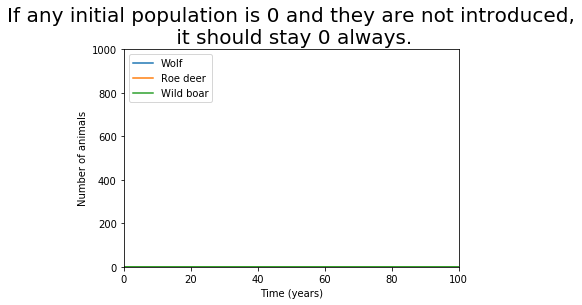

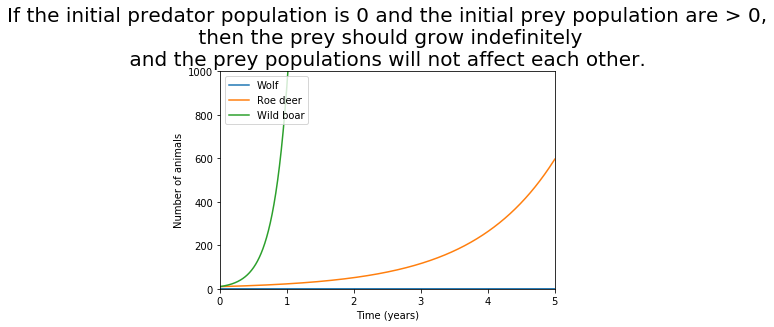

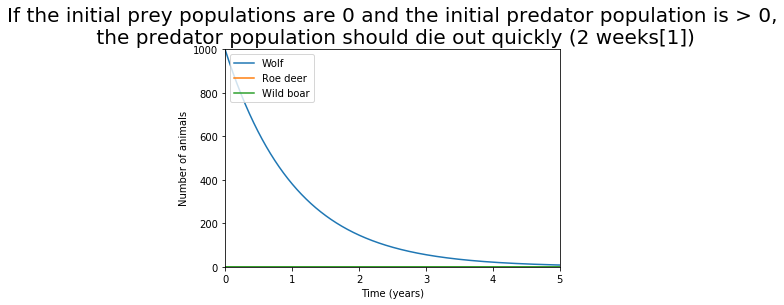

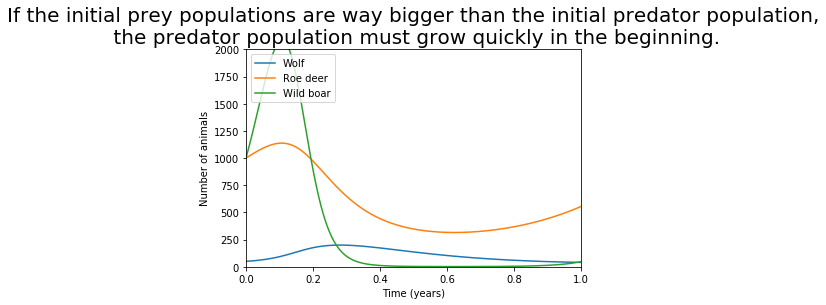

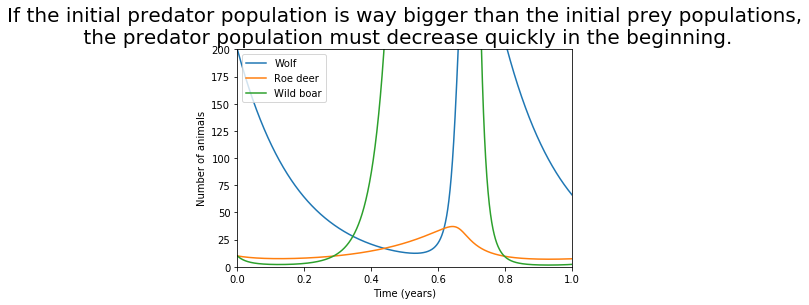

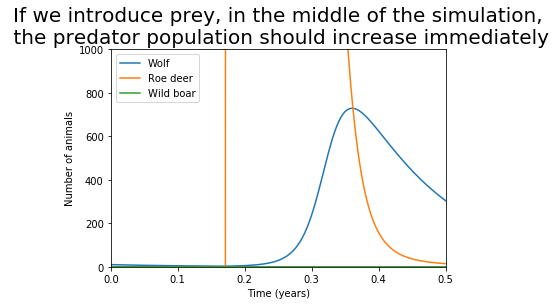

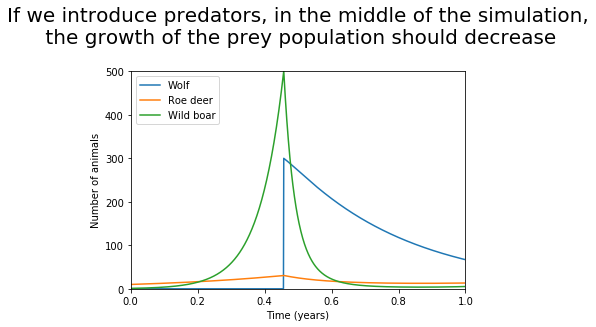

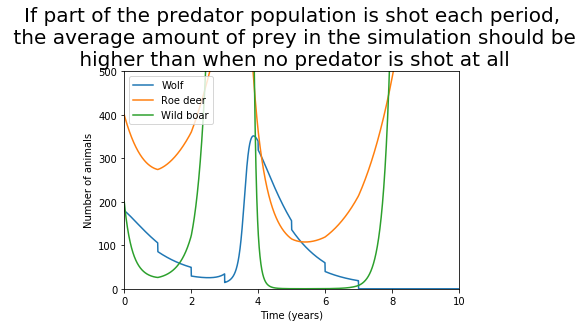

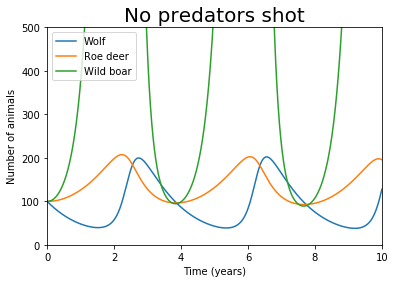

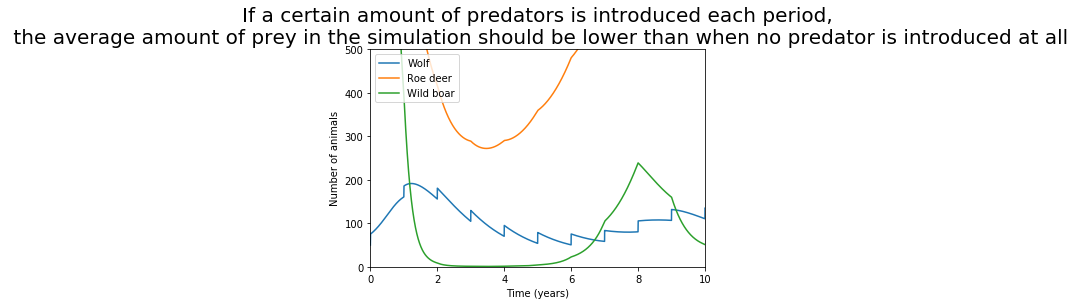

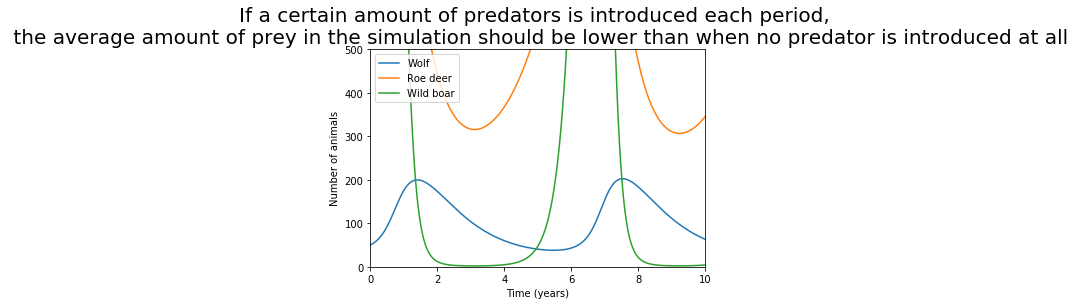

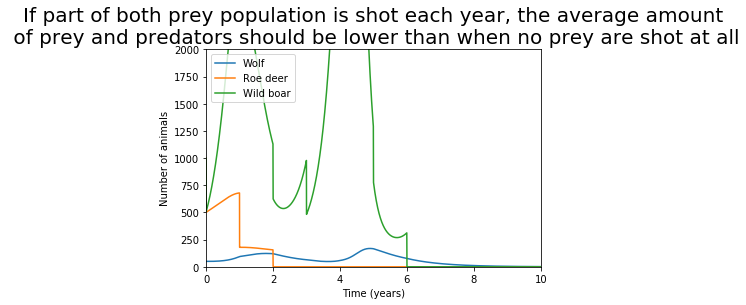

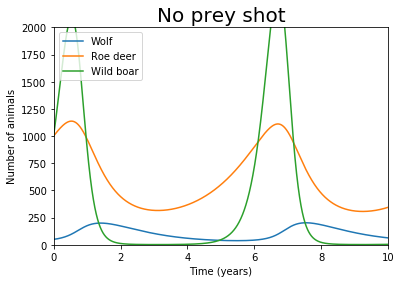

In [215]:
# If any initial population is 0 and they are not introduced, it should stay 0 always.
title = "If any initial population is 0 and they are not introduced,\n it should stay 0 always."
scale = 1
plot_prey = True
start_x = 0
end_x = 100
start_y = 0
end_y = 1000
xy_lim = [start_x, end_x, start_y, end_y]
verification(0, 0, 0, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey, False, False, [0, 100, 0, 1000])

# If the initial predator population is 0 and the initial prey population are >0, 
# then the prey should grow indefinitely.
title = "If the initial predator population is 0 and the initial prey population are > 0,\n then the prey should grow indefinitely\n and the prey populations will not affect each other. " 
verification(0, 10, 10, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey, False, False, [0, 5, 0, 1000])

# title = "If the initial predator population is 0 and the initial prey population are >0,\n then the prey should grow indefinitely (Wild Boar)." 
# # If the initial predator population is 0 and the initial prey population are >0, 
# # then the prey should grow indefinitely.
# verification(0, 0, 10, step1, 365, 0.9, 
#             False, False, False, False, title, scale, plot_prey, False, False)

title = "If the initial prey populations are 0 and the initial predator population is > 0,\n the predator population should die out quickly (2 weeks[1])"
# If the initial prey populations are 0 and the initial predator population is >0, 
# the predator population should die out quickly (2 weeks[1])
verification(1000, 0, 0, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey, False, False, [0, 5, 0, 1000])


# If the initial prey populations are way bigger than the initial predator population,
# the predator population must grow quickly in the beginning.
title = "If the initial prey populations are way bigger than the initial predator population,\n the predator population must grow quickly in the beginning."
scale = 5
plot_prey = True
verification(50, 1000, 1000,  step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey, False, False, [0, 1, 0, 2000])

# If the initial predator population is way bigger than the initial prey populations, 
# the predator population must decrease quickly in the beginning.
title = "If the initial predator population is way bigger than the initial prey populations,\n the predator population must decrease quickly in the beginning."
scale = 6
plot_prey = True
verification(200, 10, 10, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey, False, False, [0, 1, 0, 200])

# # The 2 prey populations do not affect each other. If the initial predator population is 0, 
# # the prey populations do not show peak and valleys but are exponentially increasing lines.
# title = "The 2 prey populations do not affect each other. If the initial predator population is 0,\n the prey populations do not show peak and valleys but are exponentially increasing lines."
# scale = 6
# plot_prey = True
# verification(0, 10, 10, step1, 365, 0.9, 
#             False, False, False, False, title, scale, plot_prey, False, False)

# If we introduce prey, in the middle of the simulation, the predator population should increase immediately
title = "If we introduce prey, in the middle of the simulation,\n the predator population should increase immediately"
scale = 8
plot_prey = True
verification(10, 0, 0, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey, False, "deer", [0, 0.5, 0, 1000])

###############
# If we introduce predators, in the middle of the simulation, the growth of the prey population should decrease
title = "If we introduce predators, in the middle of the simulation,\n the growth of the prey population should decrease\n"
scale = 3
plot_prey = True
verification(0, 10, 1, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey, False, "wolf", [0, 1, 0, 500])


# If part of the predator population is shot each period,
# the average amount of prey in the simulation should be higher than when no predator is shot at all
title = "If part of the predator population is shot each period,\n the average amount of prey in the simulation should be\n higher than when no predator is shot at all"
scale = 1
plot_prey = True
verification(200, 400, 200, step1, 365, 20, 
            "none", "none", "static", False, title, scale, plot_prey, False, False, [0, 10, 0, 500])

# If part of the predator population is shot each period,
# the average amount of prey in the simulation should be
# higher than when no predator is shot at all
title = "No predators shot"
scale = 1
plot_prey = True
verification(100, 100, 100, step1, 365, 0, 
            "none", "none", "none", False, title, scale, plot_prey, False, False, [0, 10, 0, 500])
    
title = "If a certain amount of predators is introduced each period,\n the average amount of prey in the simulation should be lower than when no predator is introduced at all"
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 2.5, 
            "none", "none", "none", True, title, scale, plot_prey, False, False, [0, 10, 0, 500])

title = "If a certain amount of predators is introduced each period, \n the average amount of prey in the simulation should be lower than when no predator is introduced at all"
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 0, 
            "none", "none", "none", False, title, scale, plot_prey, False, False, [0, 10, 0, 500])

title = "If part of both prey population is shot each year, the average amount\n of prey and predators should be lower than when no prey are shot at all"
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 500, 
            "static", "static", "none", False, title, scale, plot_prey, False, False, [0, 10, 0, 2000])

title = "No prey shot"
scale = 1
plot_prey = True
verification(50, 1000, 1000, step1, 365, 0, 
            "static", "static", "none", False, title, scale, plot_prey, False, False, [0, 10, 0, 2000])


# Model validation

The amount of periods without any events is  10  periods.


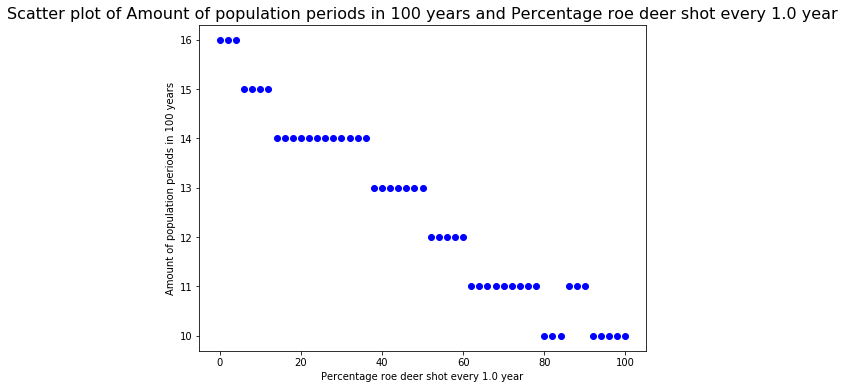

Significant correlation? True


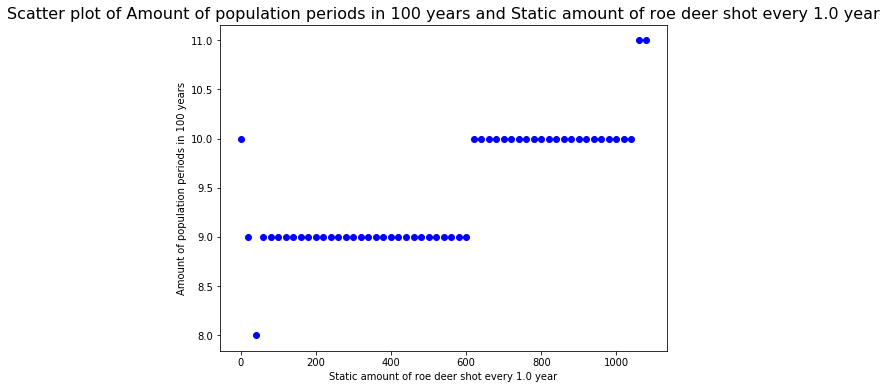

Significant correlation? True


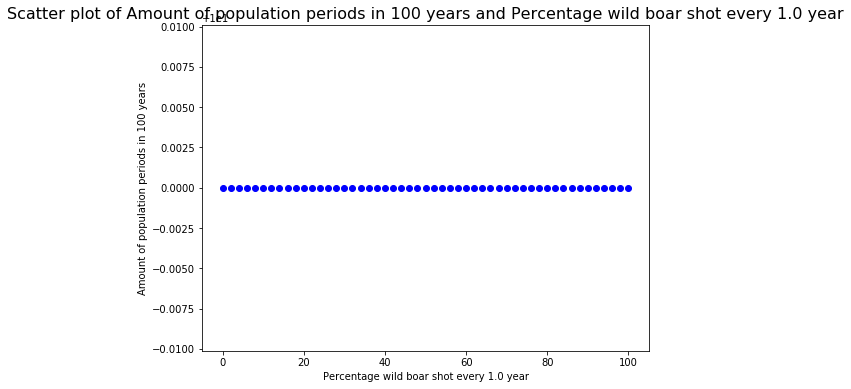

Significant correlation? False


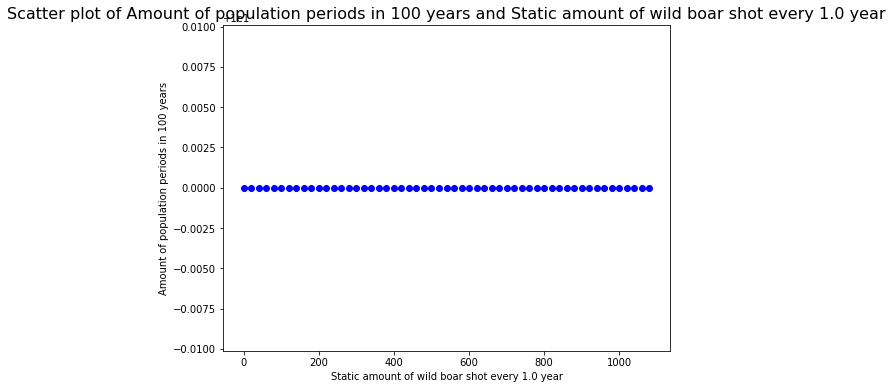

Significant correlation? False


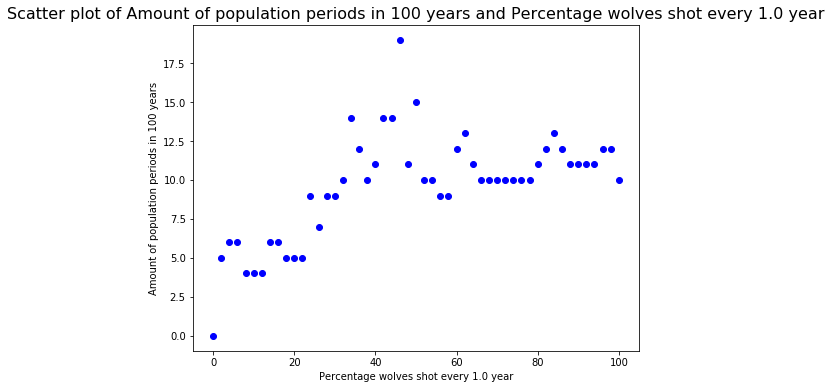

Significant correlation? False


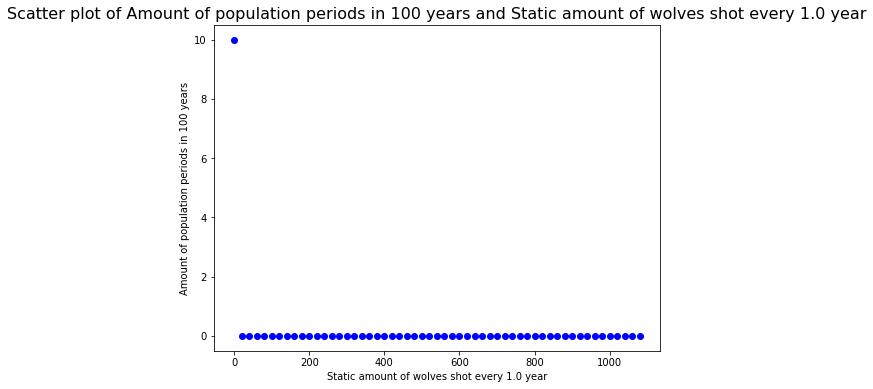

Significant correlation? True


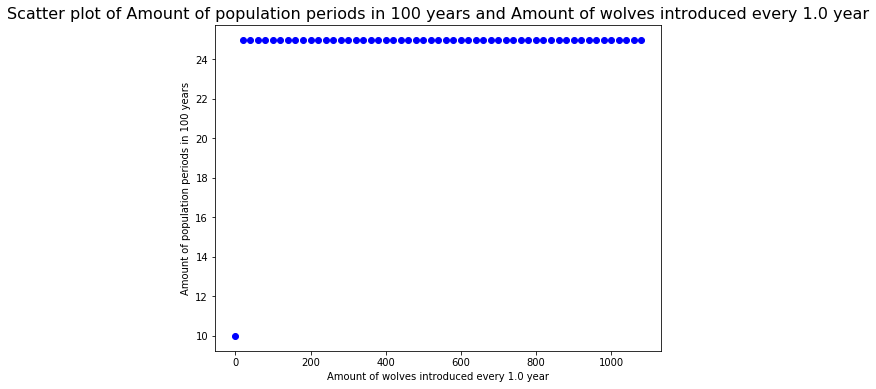

Significant correlation? True


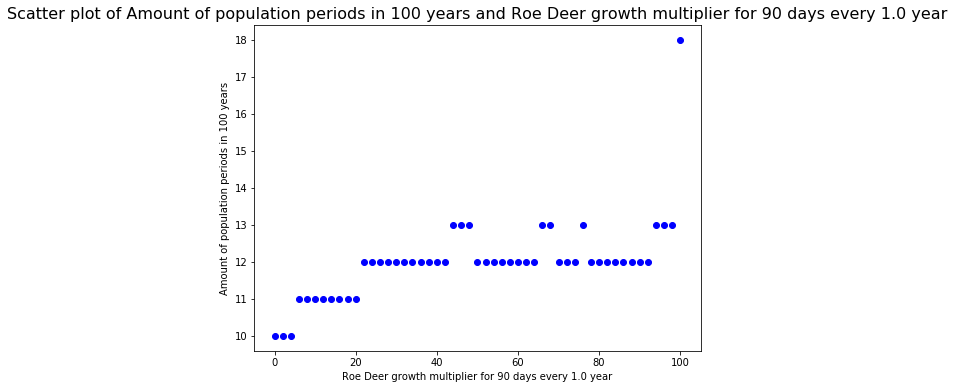

Significant correlation? True


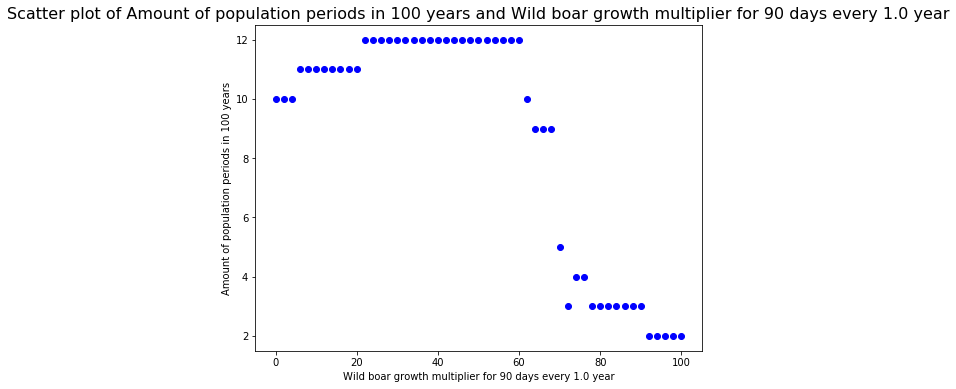

Significant correlation? True


In [216]:
params = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none', False, False, False]

# Results without any alterations
mean_r = periodicity(0, [0], params)
print('The amount of periods without any events is ', mean_r[0], " periods.")

# Deer shooting

# shoot percentage of deer
params[6] = 'percentage'
spod_results = periodicity(0, np.arange(0, 1.02, 0.02), params)
make_scatter_plot(np.arange(0, 102, 2), spod_results, 
                  'Percentage roe deer shot every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(spod_results, mean_r[0]))

# shoot set amount of deer
params[6] = 'static'
ssaod_results = periodicity(0, np.arange(0, 1100, 20), params)
params[6] = 'none'
make_scatter_plot(np.arange(0, 1100, 20), ssaod_results, 
                  'Static amount of roe deer shot every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(ssaod_results, mean_r[0]))

# Wild boar shooting

# shoot percentage of wild boar
params[7] = 'percentage'
spowb_results = periodicity(0, np.arange(0, 1.02, 0.02), params)
make_scatter_plot(np.arange(0, 102, 2), spowb_results, 
                  'Percentage wild boar shot every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(spowb_results, mean_r[0]))

# shoot set amount of wild boar
params[7] = 'static'
ssaowb_results = periodicity(0, np.arange(0, 1100, 20), params)
params[7] = 'none'
make_scatter_plot(np.arange(0, 1100, 20), ssaowb_results, 
                  'Static amount of wild boar shot every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(ssaowb_results, mean_r[0]))


# Wolf shooting

# shoot percentage of wolves
params[8] = 'percentage'
spow_results = periodicity(0, np.arange(0, 1.02, 0.02), params)
make_scatter_plot(np.arange(0, 102, 2), spow_results, 
                  'Percentage wolves shot every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(spow_results, mean_r[0]))

# shoot set amount of wolves
params[8] = 'static'
ssaow_results = periodicity(0, np.arange(0, 1100, 20), params)
params[8] = 'none'
make_scatter_plot(np.arange(0, 1100, 20), ssaow_results, 
                  'Static amount of wolves shot every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(ssaow_results, mean_r[0]))


# introduce set amount of wolves
params[9] = 'True'
iw_results = periodicity(0, np.arange(0, 1100, 20), params)
params[9] = 'False'
make_scatter_plot(np.arange(0, 1100, 20), iw_results, 
                  'Amount of wolves introduced every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(iw_results, mean_r[0]))


# severe winters
params[10] = 'True'
swd_results = periodicity(1, np.arange(0, 1.02, 0.02), params)
swb_results = periodicity(2, np.arange(0, 1.02, 0.02), params)
params[10] = 'False'
make_scatter_plot(np.arange(0, 102, 2), swd_results, 
                  'Roe Deer growth multiplier for 90 days every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(swd_results, mean_r[0]))

make_scatter_plot(np.arange(0, 102, 2), swb_results, 
                  'Wild boar growth multiplier for 90 days every %s year' % str(params[4]/365.25), 
                  'Amount of population periods in 100 years')
print('Significant correlation? %s' % test_significance(swb_results, mean_r[0]))

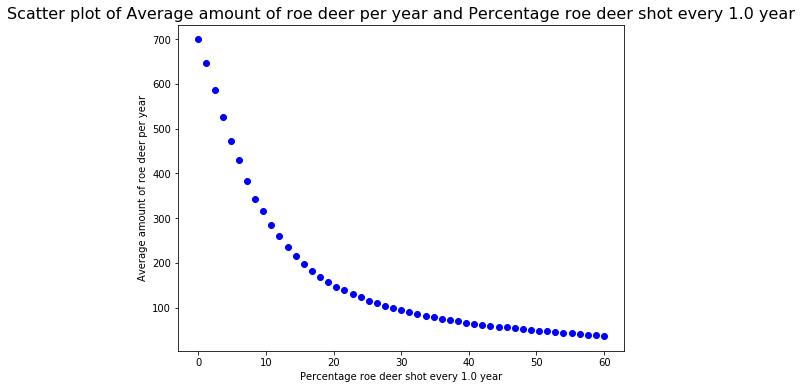

Significant correlation? True


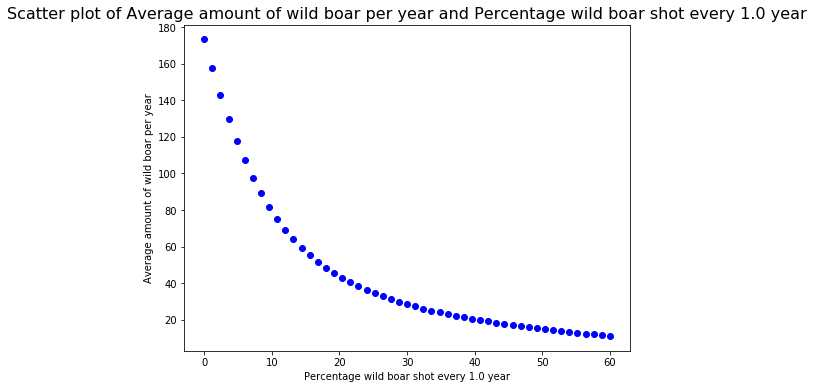

Significant correlation? True


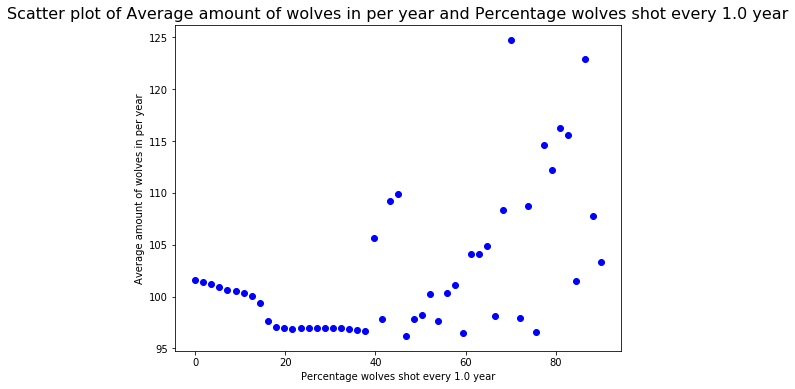

Significant correlation? False


In [217]:
# Make time array so integral can be calculated
t = range(int(36526))
t = [step1*x for x in t]

# Calculate avg amount of animals if no events happen.
params_noevents = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none', False, False, False]
wolf_array, deer_array, boar_array = lotka_volterra(params_noevents)
mean_wolf = average_amount_array(wolf_array, t)
mean_deer = average_amount_array(deer_array, t)
mean_boar = average_amount_array(boar_array, t)

# Make the params for the lotka-volterra funciton.
params_per = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none', False, False, False]

# Make data points for the different species.
params_per[6] = 'percentage'
per_r, res_r = avg_animals_integrate(1, 0, 60, 50, params_per, t) # Roe deer
params_per[6] = 'none'
params_per[7] = 'percentage'
per_b, res_b = avg_animals_integrate(2, 0, 60, 50, params_per, t) # Wild boar
params_per[7] = 'none'
params_per[8] = 'percentage'
per_w, res_w = avg_animals_integrate(0, 0, 90, 50, params_per, t) # Wolves

# Make scatter plots for the different species.
make_scatter_plot(per_r, res_r, 'Percentage roe deer shot every %s year' % str(params_per[4]/365.25), 
                  'Average amount of roe deer per year')
print('Significant correlation? %s' % test_significance(res_r, mean_deer))

make_scatter_plot(per_b, res_b, 'Percentage wild boar shot every %s year' % str(params_per[4]/365.25), 
                  'Average amount of wild boar per year')
print('Significant correlation? %s' % test_significance(res_b, mean_boar))

make_scatter_plot(per_w, res_w, 'Percentage wolves shot every %s year' % str(params_per[4]/365.25), 
                  'Average amount of wolves in per year')
print('Significant correlation? %s' % test_significance(res_w, mean_wolf))


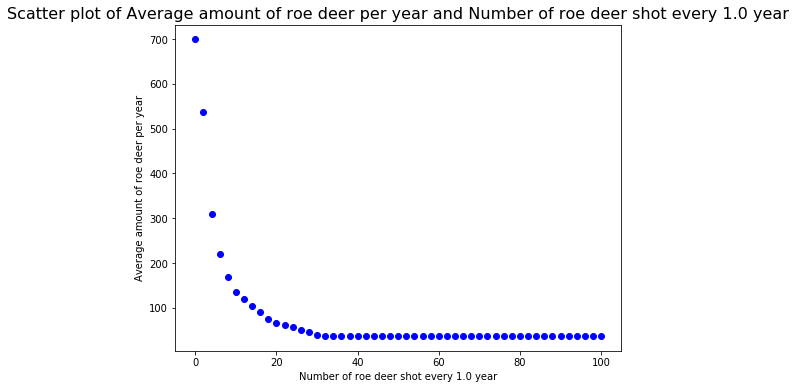

Significant correlation? True


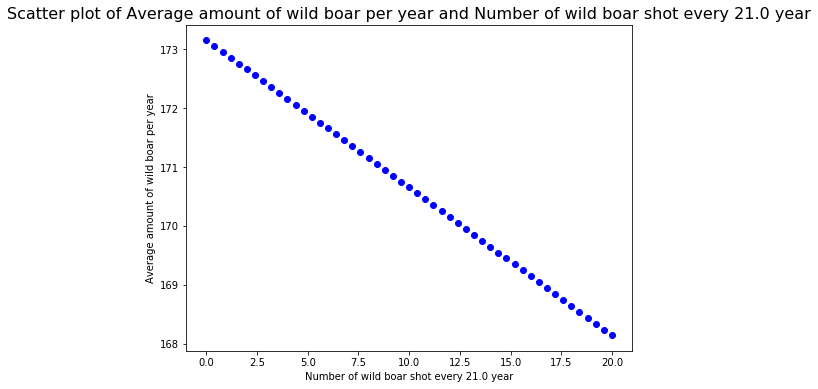

Significant correlation? True


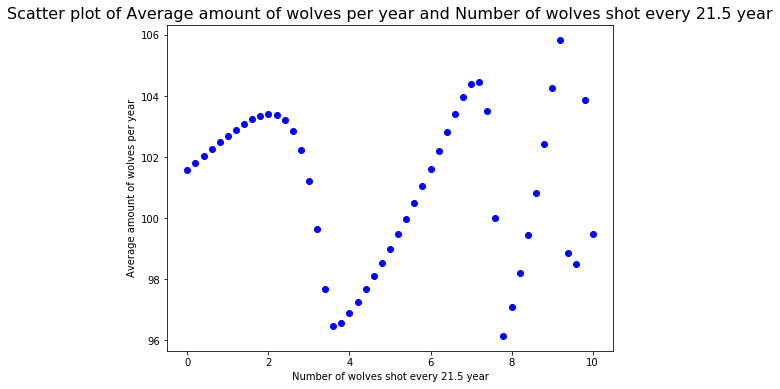

Significant correlation? False


In [218]:
params_num = [init_wolf, init_deer, init_boar, step1, 365.25, 0, 'static', 'none', 'none', False, False, False]

# Make data points for the different species.
period_deer = params_num[4]
num_r, num_res_r = avg_animals_integrate(1, 0, 100, 50, params_num, t, type='num') # Roe deer
params_num[6] = 'none'
params_num[7] = 'static'
params_num[4] = 21*365.25
period_boar = params_num[4]
num_b, num_res_b = avg_animals_integrate(2, 0, 20, 50, params_num, t, type='num') # Wild boar
params_num[7] = 'none'
params_num[8] = 'static'
params_num[4] = 21.5*365.25
num_w, num_res_w = avg_animals_integrate(0, 0, 10, 50, params_num, t, type='num') # Wolves

# Make scatter plots for the different species.
make_scatter_plot(num_r, num_res_r, 'Number of roe deer shot every %s year' % str(period_deer/365.25), 
                  'Average amount of roe deer per year')
print('Significant correlation? %s' % test_significance(num_res_r, mean_deer))

make_scatter_plot(num_b, num_res_b, 'Number of wild boar shot every %s year' % str(period_boar/365.25), 
                  'Average amount of wild boar per year')
print('Significant correlation? %s' % test_significance(num_res_b, mean_boar))

make_scatter_plot(num_w, num_res_w, 'Number of wolves shot every %s year' % str(params_num[4]/365.25), 
                  'Average amount of wolves per year')
print('Significant correlation? %s' % test_significance(num_res_w, mean_wolf))

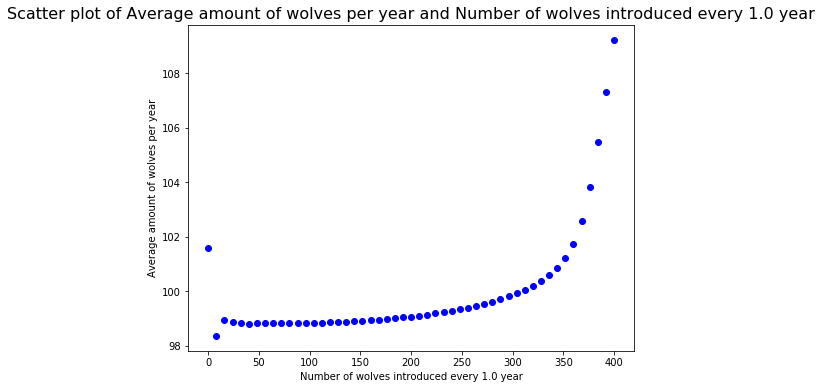

Significant correlation? True


In [219]:
# Average amount of animals and percentage of wolves introduced
params_wolf = [init_wolf, init_deer, init_boar, step1, 365.25, 0, 'none', 'none', 'none', True, False, False]

# Make data points for the different species.
wolf_num, wolf_res = avg_animals_integrate(0, 0, 40, 50, params_wolf, t, type='num')
wolf_num *= 10

# Make scatter plots for the different species.
make_scatter_plot(wolf_num, wolf_res, 'Number of wolves introduced every %s year' % str(params_wolf[4]/365.25), 
                  'Average amount of wolves per year')
print('Significant correlation? %s' % test_significance(wolf_res, mean_wolf))

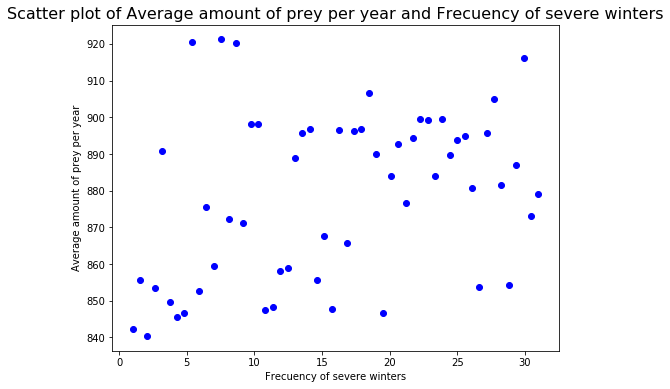

Significant correlation? True


In [220]:
# Average amount of animals and frequency of severe winters. In severe winter growth is decreased with 9/10.
params_winter = [init_wolf, init_deer, init_boar, step1, 365.25, 0.9, 'none', 'none', 'none', 
                 False, True, False]

# Make data points for severe winter
per_win, tot_prey = avg_animals_winters(365.25, 31*365.25, 55, params_winter, t)
per_win /= 365.25

# Calculate mean, no events happening.
params_mean = [init_wolf, init_deer, init_boar, step1, 365.25, 0.75, 'none', 'none', 'none', 
               False, False, False]
tot_mean = mean_deer + mean_boar

make_scatter_plot(per_win, tot_prey, 'Frecuency of severe winters', 
                  'Average amount of prey per year')
print('Significant correlation? %s' % test_significance(tot_prey, tot_mean))